In [ ]:
import os
import pickle

from fastfusion.frontend.arch import Memory
from fastfusion.frontend.specification import Specification

import copy
import time
from fastfusion import Specification
from fastfusion.mapper import Metrics

from fastfusion.mapper.FFM._pmapping_group import PmappingGroup
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

# TODO: Make a setting for the below two in the spec
# TODO: Generate pmappings one Einsum at a time. Once we've made compatibility, check it
# against the previously-generated compatibilities and stop if there's no match.
# TODO: Once the previous is done, also add a forward check. Once the compatibilities of
# a particular Einsum are generated, we can immediately check the previous Einsums.

objective = lambda df: df['Total<SEP>latency']# * df['Total_Energy']
LOAD_FROM_CACHE = True

def get_fused_mappings(
        spec: Specification, 
        cache_key=None,
        parameterization="",
    ) -> PmappingGroup:
    os.makedirs("cache", exist_ok=True)
    if cache_key is not None:
        fname = parameterization + "-".join(str(x) for x in cache_key)
        if LOAD_FROM_CACHE and os.path.exists(f"cache/{fname}.pkl"):
            print(f"Loading from cache: {fname}")
            mappings = pickle.load(open(f"cache/{fname}.pkl", "rb"))
            return objective(mappings.data).min() if mappings is not None else None, mappings
    spec = copy.deepcopy(spec)
    
    main_memory: Memory = spec.arch.nodes["MainMemory"]
    if parameterization == "Unfused":
        main_memory.constraints.tensors.keep = "All()"
    elif parameterization == "FlashAttention B":
        main_memory.constraints.tensors.keep = "~bypass"
        main_memory.constraints.tensors.bypass = "I | Q | K | V | QK | QK_softmax"#Q | K | V | I"# | QK | FFA"
    elif parameterization == "FlashAttention A":
        main_memory.constraints.tensors.keep = "~bypass"
        main_memory.constraints.tensors.bypass = "QK | QK_softmax"#Q | K | V | I"# | QK | FFA"
    elif parameterization == "FFM":
        main_memory.constraints.tensors.keep = "~Intermediates()" #"# | AV | Z "
        pass
    elif parameterization == "Fixed-Dataflow":
        main_memory.constraints.tensors.keep = "~Intermediates() | weight"
        spec.arch.nodes["GlobalBuffer"].constraints.dataflow.tensor_order_options = [
            ["MainMemory.tensors() & weight", "MainMemory.tensors() & input", "MainMemory.tensors() & output", "weight - MainMemory.tensors()", "input - MainMemory.tensors()", "output - MainMemory.tensors()"],
        ]
    else:
        assert False, f"Parameterization {parameterization} not supported"

    if LOAD_FROM_CACHE and cache_key is not None and os.path.exists(f"pmappings_cache/{fname}.pkl"):
        print(f"Loading from cache: {fname}")
        pmappings = pickle.load(open(f"cache/pmappings_{fname}.pkl", "rb"))
    else:
        pmappings = make_pmappings(spec)
        pickle.dump(pmappings, open(f"cache/pmappings_{fname}.pkl", "wb"))
    try:
        mappings = join_pmappings(spec, pmappings)
    except:
        mappings = None

    # TODO: the final joined pmappings have lambdas somewhere, which can't be pickled.
    if cache_key is not None:
        pickle.dump(mappings, open(f"cache/{fname}.pkl", "wb"))
        
    return objective(mappings.data).min() if mappings is not None else None, mappings

parameterization2edp = {}
parameterization2mappings = {}


# ================== Exploration Parameters ====================================
MAPSPACES = ["unfused", "flashattention a", "flashattention b", "fixed-dataflow", "ffm"]

# Tuple of (batch_size, n_tokens)
WORKLOAD_SHAPES = [(64, 512), (1, 8192), (1, 32768)]

# Number of cores in the TPU-like architecture
N_CORES = [256]


for batch_size, n_tokens in WORKLOAD_SHAPES:
        for n_cores in N_CORES:
            spec = Specification.from_yaml(
                f"architecture/tpu_like_asplos.arch.yaml",
                "workloads/mha_full.workload.yaml",
                # "workloads/matmuls8_mixed.workload.yaml",
                jinja_parse_data={
                    "BATCH_SIZE": batch_size,
                    "N_TOKENS": n_tokens,
                    "N_PES": n_cores,
                }
            )
            spec.mapper.ffm.metrics = Metrics.LATENCY
            cache_key = (batch_size, n_tokens, n_cores)
            spec.arch.nodes["LocalBuffer"].spatial["Z"].fanout = n_cores
            for parameterization in MAPSPACES:
                x, mappings = get_fused_mappings(
                    spec,
                    cache_key=cache_key,
                    parameterization=parameterization,
                )
                parameterization2edp.setdefault((batch_size, n_tokens, n_cores), {})[parameterization] = x
                parameterization2mappings.setdefault((batch_size, n_tokens, n_cores), {})[parameterization] = mappings

WARNING Loading configuration file from /home/gilbertm/work/venv/fastfusion/config.yaml
Generating pmapping templates for compute scalar_unit Einsum QK: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum I: 1it [00:00,  7.83it/s]
Generating pmapping templates for compute scalar_unit Einsum QK_softmax: 2it [00:00, 12.66it/s]
Generating pmapping templates for compute scalar_unit Einsum K: 0it [00:00, ?it/s]s]
Generating pmapping templates for compute scalar_unit Einsum Z: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum FFA: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum V: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]8it/s]
Generating pmapping templates for compute MAC Einsum V: 8it [00:00, 54.42it/s]
Generating pmapping templates for compute MAC Einsum Q: 8it [00:0

Einsum I has 1 pmappings with 1 compatibilities
Einsum V has 8 pmappings with 8 compatibilities
Einsum K has 8 pmappings with 8 compatibilities
Einsum Q has 8 pmappings with 8 compatibilities
Einsum QK has 8 pmappings with 8 compatibilities
Einsum QK_softmax has 2 pmappings with 2 compatibilities
Einsum AV has 8 pmappings with 8 compatibilities
Einsum Z has 8 pmappings with 8 compatibilities
Einsum FFA has 8 pmappings with 8 compatibilities
Einsum FFB has 8 pmappings with 8 compatibilities


Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 16384.00it/s]
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]]t [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum I: 1it [00:00, 15.11it/s]
Generating pmapping templates for compute scalar_unit Einsum V: 0it [00:00, ?it/s]]
Generating pmapping templates for compute scalar_unit Einsum K: 0it [00:00, ?it/s]]
Generating pmapping templates for compute scalar_unit Einsum Q: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum QK_softmax: 2it [00:00, 23.88it/s]
Generating pmapping templates for compute scalar_unit Einsum QK: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum AV: 0it [00:00, ?it/s]]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum Z: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum FFB: 0it 

Einsum I has 1 pmappings with 1 compatibilities
Einsum V has 8 pmappings with 8 compatibilities
Einsum K has 8 pmappings with 8 compatibilities
Einsum Q has 8 pmappings with 8 compatibilities
Einsum QK has 1895 pmappings with 1895 compatibilities
Einsum QK_softmax has 8370 pmappings with 8370 compatibilities
Einsum AV has 1895 pmappings with 1895 compatibilities
Einsum Z has 8 pmappings with 8 compatibilities
Einsum FFA has 8 pmappings with 8 compatibilities
Einsum FFB has 8 pmappings with 8 compatibilities


Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 20460.02it/s]
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]0, ?it/s], ?it/s]
Generating pmapping templates for compute scalar_unit Einsum V: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum K: 0it [00:00, ?it/s]s]
Generating pmapping templates for compute scalar_unit Einsum I: 2it [00:00, 23.89it/s]
Generating pmapping templates for compute scalar_unit Einsum QK: 0it [00:00, ?it/s]]
Generating pmapping templates for compute scalar_unit Einsum QK_softmax: 2it [00:00, 21.88it/s]
Generating pmapping templates for compute scalar_unit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum Q: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum FFA: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum FFB: 0i

Einsum I has 1820 pmappings with 1820 compatibilities
Einsum V has 3150 pmappings with 3150 compatibilities
Einsum K has 3150 pmappings with 3150 compatibilities
Einsum Q has 3150 pmappings with 3150 compatibilities
Einsum QK has 835 pmappings with 835 compatibilities
Einsum QK_softmax has 8370 pmappings with 8370 compatibilities
Einsum AV has 1050 pmappings with 1050 compatibilities
Einsum Z has 8 pmappings with 8 compatibilities
Einsum FFA has 8 pmappings with 8 compatibilities
Einsum FFB has 8 pmappings with 8 compatibilities


Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 20164.92it/s]
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]0, ?it/s], ?it/s]
Generating pmapping templates for compute scalar_unit Einsum K: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum I: 3it [00:00, 35.15it/s]
Generating pmapping templates for compute scalar_unit Einsum Q: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum FFB: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum V: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum FFA: 0it [00:00, ?it/s] 17.41it/s]
Generating pmapping templates for compute scalar_unit Einsum FFB: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum QK_softma

Einsum I has 1821 pmappings with 1821 compatibilities
Einsum V has 3260 pmappings with 3260 compatibilities
Einsum K has 3260 pmappings with 3260 compatibilities
Einsum Q has 3260 pmappings with 3260 compatibilities
Einsum QK has 1096 pmappings with 1096 compatibilities
Einsum QK_softmax has 12556 pmappings with 12556 compatibilities
Einsum AV has 775 pmappings with 775 compatibilities
Einsum Z has 2240 pmappings with 2240 compatibilities
Einsum FFA has 1381 pmappings with 1381 compatibilities
Einsum FFB has 526 pmappings with 526 compatibilities


Merging pmappings for FFA <--> FFB (10/10): 100%|██████████| 266/266 [00:00<00:00, 1167.12it/s]
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]0, ?it/s], ?it/s]
Generating pmapping templates for compute scalar_unit Einsum V: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum K: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum Q: 0it [00:00, ?it/s]t/s]
Generating pmapping templates for compute scalar_unit Einsum I: 3it [00:00, 20.96it/s]
Generating pmapping templates for compute scalar_unit Einsum QK: 0it [00:00, ?it/s]]
Generating pmapping templates for compute MAC Einsum QK: 2it [00:00, 18.88it/s]t/s]]
Generating pmapping templates for compute scalar_unit Einsum Z: 0it [00:00, ?it/s]0, 27.91it/s]
Generating pmapping templates for compute scalar_unit Einsum FFA: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for com

Einsum I has 911 pmappings with 911 compatibilities
Einsum V has 6812 pmappings with 6812 compatibilities
Einsum K has 6812 pmappings with 6812 compatibilities
Einsum Q has 6812 pmappings with 6812 compatibilities
Einsum QK has 5549 pmappings with 5549 compatibilities
Einsum QK_softmax has 16741 pmappings with 16741 compatibilities
Einsum AV has 5549 pmappings with 5549 compatibilities
Einsum Z has 6812 pmappings with 6812 compatibilities
Einsum FFA has 3223 pmappings with 3223 compatibilities
Einsum FFB has 1155 pmappings with 1155 compatibilities


Merging pmappings for FFA <--> FFB (10/10): 100%|██████████| 271/271 [00:00<00:00, 1138.96it/s]
WARNING Loading configuration file from /home/gilbertm/work/venv/fastfusion/config.yaml
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s], ?it/s]
Generating pmapping templates for compute scalar_unit Einsum I: 1it [00:00, 15.23it/s]
Generating pmapping templates for compute scalar_unit Einsum V: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum K: 0it [00:00, ?it/s]s]
Generating pmapping templates for compute scalar_unit Einsum QK: 0it [00:00, ?it/s]]
Generating pmapping templates for compute scalar_unit Einsum Q: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum Z: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum FFA: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_

Einsum I has 1 pmappings with 1 compatibilities
Einsum V has 8 pmappings with 8 compatibilities
Einsum K has 8 pmappings with 8 compatibilities
Einsum Q has 8 pmappings with 8 compatibilities
Einsum QK has 8 pmappings with 8 compatibilities
Einsum QK_softmax has 2 pmappings with 2 compatibilities
Einsum AV has 8 pmappings with 8 compatibilities
Einsum Z has 8 pmappings with 8 compatibilities
Einsum FFA has 8 pmappings with 8 compatibilities
Einsum FFB has 8 pmappings with 8 compatibilities


Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 23967.45it/s]
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]0, ?it/s], ?it/s]
Generating pmapping templates for compute scalar_unit Einsum I: 1it [00:00, 14.70it/s]
Generating pmapping templates for compute scalar_unit Einsum V: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum K: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum Q: 0it [00:00, ?it/s]]
Generating pmapping templates for compute scalar_unit Einsum QK: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum QK_softmax: 2it [00:00, 21.44it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum Z: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum AV: 0it [00:00, ?it/s]]
Generating pmapping templates for compute scalar_unit Einsum FFA: 0it [

Einsum I has 1 pmappings with 1 compatibilities
Einsum V has 8 pmappings with 8 compatibilities
Einsum K has 8 pmappings with 8 compatibilities
Einsum Q has 8 pmappings with 8 compatibilities
Einsum QK has 1736 pmappings with 1736 compatibilities
Einsum QK_softmax has 2282 pmappings with 2282 compatibilities
Einsum AV has 1736 pmappings with 1736 compatibilities
Einsum Z has 8 pmappings with 8 compatibilities
Einsum FFA has 8 pmappings with 8 compatibilities
Einsum FFB has 8 pmappings with 8 compatibilities


Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 28339.89it/s]
Generating pmapping templates for compute scalar_unit Einsum K: 0it [00:00, ?it/s]], ?it/s]
Generating pmapping templates for compute scalar_unit Einsum Q: 0it [00:00, ?it/s]s]
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum QK: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum I: 2it [00:00, 16.28it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum QK: 6it [00:00, 51.93it/s]
Generating pmapping templates for compute scalar_unit Einsum FFA: 0it [00:00, ?it/s]
Generating jobs:   5%|▌         | 1/20 [00:00<00:03,  5.89it/s]_softmax: 2it [00:00, 14.73it/s]
Generating pmapping templates for compute scalar_unit Einsum Z: 0it [00:00, ?it/

Einsum I has 364 pmappings with 364 compatibilities
Einsum V has 558 pmappings with 558 compatibilities
Einsum K has 558 pmappings with 558 compatibilities
Einsum Q has 558 pmappings with 558 compatibilities
Einsum QK has 495 pmappings with 495 compatibilities
Einsum QK_softmax has 2282 pmappings with 2282 compatibilities
Einsum AV has 732 pmappings with 732 compatibilities
Einsum Z has 8 pmappings with 8 compatibilities
Einsum FFA has 8 pmappings with 8 compatibilities
Einsum FFB has 8 pmappings with 8 compatibilities


Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 21509.25it/s]
Generating pmapping templates for compute scalar_unit Einsum V: 0it [00:00, ?it/s]], ?it/s]
Generating pmapping templates for compute scalar_unit Einsum FFA: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum I: 3it [00:00, 32.88it/s]
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]]
Generating pmapping templates for compute scalar_unit Einsum QK: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum K: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum FFB: 0it [00:00, ?it/s]  7.72it/s]
Generating pmapping templates for compute scalar_unit Einsum Z: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum QK_softmax: 4it [

Einsum I has 365 pmappings with 365 compatibilities
Einsum V has 578 pmappings with 578 compatibilities
Einsum K has 578 pmappings with 578 compatibilities
Einsum Q has 578 pmappings with 578 compatibilities
Einsum QK has 912 pmappings with 912 compatibilities
Einsum QK_softmax has 3424 pmappings with 3424 compatibilities
Einsum AV has 520 pmappings with 520 compatibilities
Einsum Z has 398 pmappings with 398 compatibilities
Einsum FFA has 246 pmappings with 246 compatibilities
Einsum FFB has 95 pmappings with 95 compatibilities


Merging pmappings for FFA <--> FFB (10/10): 100%|██████████| 48/48 [00:00<00:00, 858.42it/s]
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]] ?it/s]], ?it/s]
Generating pmapping templates for compute scalar_unit Einsum Q: 0it [00:00, ?it/s]s]
Generating pmapping templates for compute scalar_unit Einsum QK: 0it [00:00, ?it/s]]
Generating pmapping templates for compute scalar_unit Einsum K: 0it [00:00, ?it/s]t/s]
Generating pmapping templates for compute scalar_unit Einsum I: 3it [00:00, 24.43it/s]

Generating pmapping templates for compute scalar_unit Einsum FFA: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum FFB: 0it [00:00, ?it/s]  8.41it/s]
Generating pmapping templates for compute scalar_unit Einsum Z: 0it [00:00, ?it/s]
Generating pmapping templates for comp

Einsum I has 183 pmappings with 183 compatibilities
Einsum V has 1297 pmappings with 1297 compatibilities
Einsum K has 1297 pmappings with 1297 compatibilities
Einsum Q has 1297 pmappings with 1297 compatibilities
Einsum QK has 3466 pmappings with 3466 compatibilities
Einsum QK_softmax has 4565 pmappings with 4565 compatibilities
Einsum AV has 3466 pmappings with 3466 compatibilities
Einsum Z has 1297 pmappings with 1297 compatibilities
Einsum FFA has 614 pmappings with 614 compatibilities
Einsum FFB has 233 pmappings with 233 compatibilities


Merging pmappings for FFA <--> FFB (10/10): 100%|██████████| 48/48 [00:00<00:00, 616.92it/s]
WARNING Loading configuration file from /home/gilbertm/work/venv/fastfusion/config.yaml
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]0, ?it/s], ?it/s]
Generating pmapping templates for compute scalar_unit Einsum K: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum Q: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum I: 1it [00:00, 10.33it/s]
Generating pmapping templates for compute scalar_unit Einsum V: 0it [00:00, ?it/s]s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum QK_softmax: 2it [00:00, 19.43it/s]
Generating pmapping templates for compute scalar_unit Einsum FFA: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum Z: 0it [00:00, ?it/s]
Generating pmapping templates for compute

Einsum I has 1 pmappings with 1 compatibilities
Einsum V has 8 pmappings with 8 compatibilities
Einsum K has 8 pmappings with 8 compatibilities
Einsum Q has 8 pmappings with 8 compatibilities
Einsum QK has 8 pmappings with 8 compatibilities
Einsum QK_softmax has 2 pmappings with 2 compatibilities
Einsum AV has 8 pmappings with 8 compatibilities
Einsum Z has 8 pmappings with 8 compatibilities
Einsum FFA has 8 pmappings with 8 compatibilities
Einsum FFB has 8 pmappings with 8 compatibilities


Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 28926.23it/s]
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]]t [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum Z: 0it [00:00, ?it/s]]
Generating pmapping templates for compute scalar_unit Einsum I: 1it [00:00, 13.27it/s]
Generating pmapping templates for compute scalar_unit Einsum K: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum QK: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum QK_softmax: 2it [00:00, 25.48it/s]
Generating pmapping templates for compute MAC Einsum FFA: 0it [00:00, ?it/s]?it/s]
Generating pmapping templates for compute scalar_unit Einsum Z: 0it [00:00, ?it/s]s]
Generating pmapping templates for compute scalar_unit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum V: 8it [00:00, 45.90it/s]]
Generating pmapping templates for compute scalar_unit Einsum FFA: 0it [00:

Einsum I has 1 pmappings with 1 compatibilities
Einsum V has 8 pmappings with 8 compatibilities
Einsum K has 8 pmappings with 8 compatibilities
Einsum Q has 8 pmappings with 8 compatibilities
Einsum QK has 2218 pmappings with 2218 compatibilities
Einsum QK_softmax has 2762 pmappings with 2762 compatibilities
Einsum AV has 2218 pmappings with 2218 compatibilities
Einsum Z has 8 pmappings with 8 compatibilities
Einsum FFA has 8 pmappings with 8 compatibilities
Einsum FFB has 8 pmappings with 8 compatibilities


Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 23172.95it/s]
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]], ?it/s], ?it/s]
Generating pmapping templates for compute scalar_unit Einsum V: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum Q: 0it [00:00, ?it/s]s]
Generating pmapping templates for compute scalar_unit Einsum K: 0it [00:00, ?it/s]s]
Generating pmapping templates for compute scalar_unit Einsum QK_softmax: 2it [00:00, 21.28it/s]
Generating pmapping templates for compute scalar_unit Einsum FFA: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum Z: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum QK: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum FFB: 0it [

Einsum I has 416 pmappings with 416 compatibilities
Einsum V has 645 pmappings with 645 compatibilities
Einsum K has 645 pmappings with 645 compatibilities
Einsum Q has 645 pmappings with 645 compatibilities
Einsum QK has 508 pmappings with 508 compatibilities
Einsum QK_softmax has 2762 pmappings with 2762 compatibilities
Einsum AV has 839 pmappings with 839 compatibilities
Einsum Z has 8 pmappings with 8 compatibilities
Einsum FFA has 8 pmappings with 8 compatibilities
Einsum FFB has 8 pmappings with 8 compatibilities


Merging pmappings for V <--> K (3/10): 100%|██████████| 7/7 [00:00<00:00, 224.43it/s]
Generating pmapping templates for compute scalar_unit Einsum V: 0it [00:00, ?it/s]s] ?it/s]
Generating pmapping templates for compute scalar_unit Einsum Q: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]s], ?it/s]
Generating pmapping templates for compute scalar_unit Einsum QK: 0it [00:00, ?it/s]/s]
Generating pmapping templates for compute scalar_unit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum K: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum I: 3it [00:00, 20.78it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum Z: 0it [00:00, ?it/s]0,  7.52it/s]
Generating pmapping templates for compute scalar_unit Einsum FFA: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar

Einsum I has 417 pmappings with 417 compatibilities
Einsum V has 671 pmappings with 671 compatibilities
Einsum K has 671 pmappings with 671 compatibilities
Einsum Q has 671 pmappings with 671 compatibilities
Einsum QK has 1096 pmappings with 1096 compatibilities
Einsum QK_softmax has 4144 pmappings with 4144 compatibilities
Einsum AV has 596 pmappings with 596 compatibilities
Einsum Z has 461 pmappings with 461 compatibilities
Einsum FFA has 263 pmappings with 263 compatibilities
Einsum FFB has 106 pmappings with 106 compatibilities


Merging pmappings for FFA <--> FFB (10/10): 100%|██████████| 54/54 [00:00<00:00, 792.03it/s]
Generating pmapping templates for compute scalar_unit Einsum K: 0it [00:00, ?it/s]s] ?it/s]
Generating pmapping templates for compute scalar_unit Einsum Q: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]s], ?it/s]
Generating pmapping templates for compute scalar_unit Einsum V: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum I: 3it [00:00, 22.13it/s]8.01it/s]
Generating pmapping templates for compute scalar_unit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum FFB: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum Z: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum QK_softmax: 8it [00:00, 52.61it/s]
Generating pmapping templates for co

Einsum I has 209 pmappings with 209 compatibilities
Einsum V has 1555 pmappings with 1555 compatibilities
Einsum K has 1555 pmappings with 1555 compatibilities
Einsum Q has 1555 pmappings with 1555 compatibilities
Einsum QK has 3923 pmappings with 3923 compatibilities
Einsum QK_softmax has 5525 pmappings with 5525 compatibilities
Einsum AV has 3923 pmappings with 3923 compatibilities
Einsum Z has 1555 pmappings with 1555 compatibilities
Einsum FFA has 684 pmappings with 684 compatibilities
Einsum FFB has 271 pmappings with 271 compatibilities


Merging pmappings for FFA <--> FFB (10/10): 100%|██████████| 59/59 [00:00<00:00, 767.31it/s]


Elementwise-Only: {'Batch=64\nTokens=512': np.float64(0.27285390803099696), 'Batch=1\nTokens=8k': np.float64(0.04927433922747447), 'Batch=1\nTokens=32k': np.float64(0.02675507038893531)}
FlashAttention A: {'Batch=64\nTokens=512': np.float64(0.45709841694467), 'Batch=1\nTokens=8k': np.float64(0.47993180829615223), 'Batch=1\nTokens=32k': np.float64(0.6504716129657209)}
FlashAttention B: {'Batch=64\nTokens=512': np.float64(0.6349826650381478), 'Batch=1\nTokens=8k': np.float64(0.6181579163585571), 'Batch=1\nTokens=32k': np.float64(0.0)}
Fixed-Dataflow: {'Batch=64\nTokens=512': np.float64(0.6770154779597468), 'Batch=1\nTokens=8k': np.float64(0.7933776231150481), 'Batch=1\nTokens=32k': np.float64(0.7128056165316785)}
Fast & Fusiest: {'Batch=64\nTokens=512': np.float64(1.0), 'Batch=1\nTokens=8k': np.float64(1.0), 'Batch=1\nTokens=32k': np.float64(1.0)}


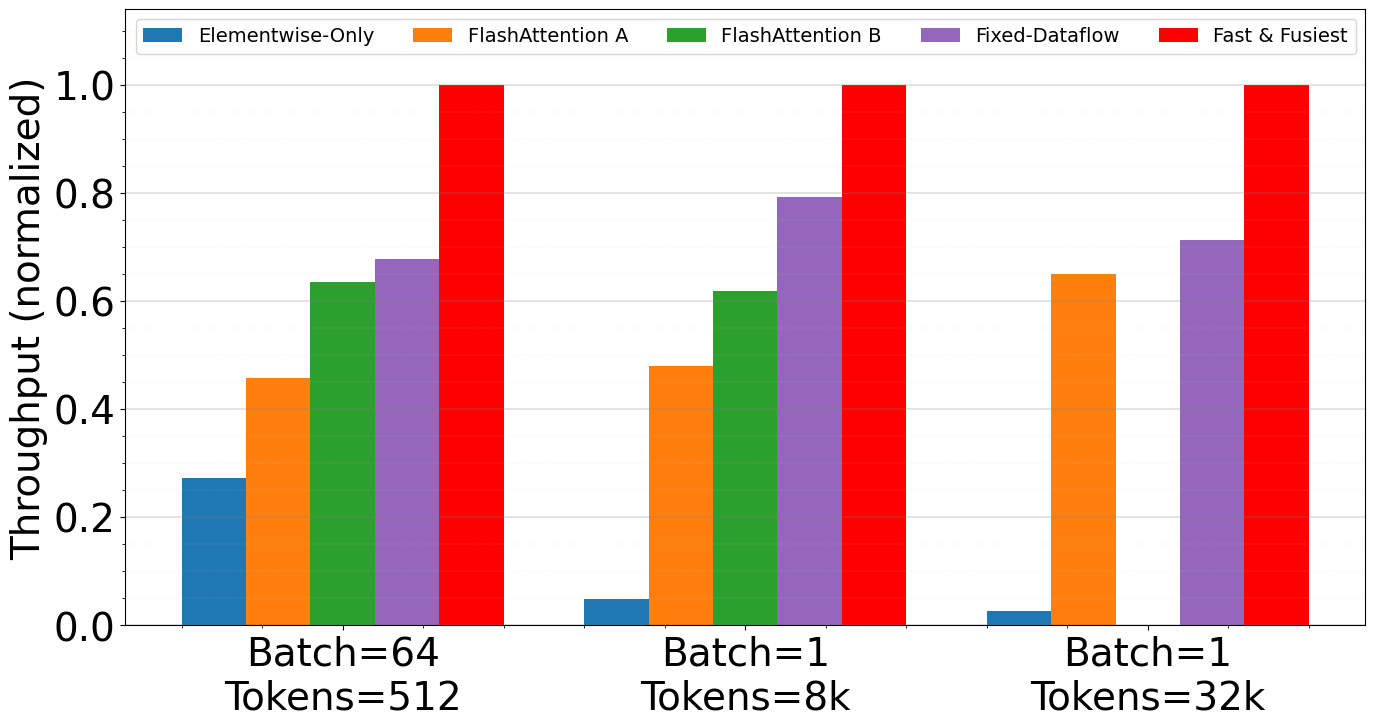

In [2]:
results = parameterization2edp

import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({'font.size': 28})

def plot_default_formatting(ax, grid_axis='both'):
    ax.tick_params(axis='both', which='major')#, labelsize=20)
    ax.tick_params(axis='both', which='minor')#, labelsize=20)
    legend = ax.legend()
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')
    # Set legend ncols to 5
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    ax.legend(fontsize=14, ncols=5)
    ax.minorticks_on()
    ax.grid(axis=grid_axis, which='major', linestyle='-', linewidth='0.3', color='gray')
    ax.grid(axis=grid_axis, which='minor', linestyle='--', linewidth='0.1', color='lightgray')

colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#9467bd",
    "#ff0000",
]

def make_bar_chart(
    data,
    title,
    xlabel,
    ylabel,
    y_scale,
    output_file=None,
    normalize: bool = False,
    ylim=(None, None),
    xlim=(None, None),
):
    """
    Create a bar chart from the given data and save it as a PDF.
    """
    plt.figure(figsize=(16, 8))
    
    if isinstance(data, dict) and isinstance(next(iter(data.values())), dict):
        bar_width = 0.8 / len(data)
        keys = list(next(iter(data.values())).keys())
        x = range(len(keys))
        first = next(iter(data.values()))
            
        for i, (label, values) in enumerate(data.items()):
            bar_positions = [pos + i * bar_width for pos in x]
            to_plot = values
            if normalize:
                to_plot = {k: v / first[k] for k, v in values.items()}
            bars = plt.bar(bar_positions, to_plot.values(), width=bar_width, label=label, color=colors[i])
        plt.xticks([pos + (len(data) - 1) * bar_width / 2 for pos in x], keys)
        # plt.legend(loc='upper right', fontsize=10)
        plt.legend(fontsize=10, ncol=len(data), loc='upper center')
    else:
        keys = list(data.keys())
        bars = plt.bar(keys, data.values())
        

    # Set logarithmic scale for Y-axis if specified
    if y_scale == 'log':
        plt.yscale('log')

    # Add labels and title
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    plt.xlim(xlim)

    # Rotate X-axis labels vertically
    # plt.xticks(rotation=90)
    
    plot_default_formatting(plt.gca(), grid_axis='y')
    
    if output_file is not None:
        with open(output_file, 'wb') as f:
            plt.savefig(f, format='pdf', bbox_inches='tight')

    # Show the plot
    plt.show()

entries = {}

name_changes = {
    "Unfused": "Elementwise-Only",
    "FlashAttention A": "FlashAttention A",
    "FlashAttention B": "FlashAttention B",
    "FFM": "Fast & Fusiest",
    # (64, 512, 64): "Big Batch\n64 Cores",
    (64, 512, 256): "Batch=64\nTokens=512",#\n256 Cores",
    # (1, 16384, 64): "Big Seq\n64 Cores",
    (1, 8192, 256): "Batch=1\nTokens=8k",#\n256 Cores",
    # (1, 32768, 256): "Bigger Seq\n256 Cores",
    (1, 32768, 256): "Batch=1\nTokens=32k",#\n256 Cores",
}

for k, v in results.items():
    if k not in name_changes:
        continue
    k = name_changes.get(k, k)
    entries[k] = {name_changes.get(k2, k2): 1/v[k2] if v[k2] else 0 for k2 in v}
    max_val = max(entries[k].values())
    for k2, v2 in entries[k].items():
        entries[k][k2] = v2 / max_val if max_val else 0
        
entries={k: v for k, v in sorted(entries.items(), key=lambda x: list(name_changes.values()).index(x[0]))}

# Transpose everything
entries2 = {}
for k, v in entries.items():
    for k2, v2 in v.items():
        entries2.setdefault(k2, {})[k] = v2
entries = entries2
        
# Print as a table
for name, e in entries2.items():
    print(f"{name}: {e}")
    
make_bar_chart(entries, title=None, xlabel=None, ylabel="Throughput (normalized)", y_scale='linear', output_file="mapsapce_compare.pdf", normalize=False, ylim=(0, 1.14), xlim=(None, None))

In [ ]:
mapping_ffm = next(iter(parameterization2mappings.values()))["FFM"]
from IPython.display import SVG
display(SVG(mapping_ffm.render()))